In [1]:
import numpy as np
import artpop
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from synthpop import adopt_a_cat, massage_the_cat
import utils as sl_utils

import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

from lsst.daf.butler import Butler, DimensionUniverse, DatasetType, CollectionType
from lsst.daf.butler.registry import MissingCollectionError
import lsst.source.injection as si

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/dustmaps_cachedata/gbb0a0c949e+81bc2a20b4/config/.dustmapsrc


In [2]:
repo="/repo/main"
collection='HSC/runs/RC2/w_2023_32/DM-40356'
butler = Butler(repo, collections=collection)
registry = butler.registry

In [3]:
dataid_g = {'band': 'g', 'skymap': 'hsc_rings_v1', 'tract': 9615, 'patch': 3}
dataid_r = {'band': 'r', 'skymap': 'hsc_rings_v1', 'tract': 9615, 'patch': 3}
dataid_i = {'band': 'i', 'skymap': 'hsc_rings_v1', 'tract': 9615, 'patch': 3}

In [4]:
coadd_g = butler.get('deepCoadd_calexp', dataId=dataid_g)

In [5]:
wcs = coadd_g.getWcs()
bbox = coadd_g.getBBox()

## Make the catalog to inject

In [6]:
cat0 = adopt_a_cat(wcs, bbox, 1000.0, 1000.0, 'g', r_scale=100.0)

In [7]:
cat_lim28 = massage_the_cat(cat0, 28.0, 'g', 1000.0, 1000.0, wcs, bbox, r_scale=100.0)
cat_lim32 = massage_the_cat(cat0, 32.0, 'g', 1000.0, 1000.0, wcs, bbox, r_scale=100.0)

In [8]:
writeable_butler =  Butler(repo, writeable=True)

si_input_collection = "u/jcarlin/my_first_starlink_dwarf"

try:
    writeable_butler.removeRuns([si_input_collection])
except MissingCollectionError:
    print("Writing into a new RUN collection")
    pass
else:
    print("Prior RUN collection located and successfully removed")

_ = writeable_butler.registry.registerCollection(si_input_collection, type=CollectionType.RUN)

Prior RUN collection located and successfully removed


In [9]:
si_dataset_type =  DatasetType(
    "si_cat",
    dimensions=["skymap", "tract"],
    storageClass="DataFrame",
    universe=DimensionUniverse(),
)

writeable_butler.registry.registerDatasetType(si_dataset_type)

False

In [10]:
dataset_ref_lim32 = si.ingest_injection_catalog(
    writeable_butler=writeable_butler,
    table=cat_lim32,
    band=dataid_g['band'],
    output_collection='u/jcarlin/starlink_dwarf_lim32d',
    dataset_type_name='injection_catalog'
)

dataset_ref_lim28 = si.ingest_injection_catalog(
    writeable_butler=writeable_butler,
    table=cat_lim28,
    band=dataid_g['band'],
    output_collection='u/jcarlin/starlink_dwarf_lim28d',
    dataset_type_name='injection_catalog'
)

print(f'{dataset_ref_lim32 = }')

dataset_ref_lim32 = [DatasetRef(DatasetType('injection_catalog', {band, htm7}, ArrowAstropy), {band: 'g', htm7: 165960}, run='u/jcarlin/starlink_dwarf_lim32d', id=fd061cb7-fe02-4aab-bfea-47b0cc6cad2f), DatasetRef(DatasetType('injection_catalog', {band, htm7}, ArrowAstropy), {band: 'g', htm7: 165988}, run='u/jcarlin/starlink_dwarf_lim32d', id=9737c162-08b8-4b46-9fcf-ab6af02df40b), DatasetRef(DatasetType('injection_catalog', {band, htm7}, ArrowAstropy), {band: 'g', htm7: 166004}, run='u/jcarlin/starlink_dwarf_lim32d', id=daf43051-be54-46ee-bc08-276d2eaccc66)]


In [11]:
inject_config = si.CoaddInjectConfig()

display(inject_config)

inject_task = si.CoaddInjectTask(config=inject_config)

lsst.source.injection.inject_coadd.CoaddInjectConfig(saveMetadata=True, saveLogOutput=True, process_all_data_ids=False, trim_padding=100, mask_plane_name='INJECTED', calib_flux_radius=12.0, fits_alignment='pixel', stamp_prefix='', col_ra='ra', col_dec='dec', col_mag='mag', col_source_type='source_type', col_stamp='stamp', col_draw_size='draw_size', col_trail_length='trail_length', connections={'injection_catalogs': '{injection_prefix}catalog', 'input_exposure': '{coadd_name}Coadd', 'output_exposure': '{injected_prefix}{coadd_name}Coadd', 'output_catalog': '{injected_prefix}{coadd_name}Coadd_catalog', 'injection_prefix': 'injection_', 'injected_prefix': 'injected_', 'coadd_name': 'deep'})

In [12]:
butler = Butler(repo)

tables_lim28 = [butler.get(ref) for ref in dataset_ref_lim28]
tables_lim32 = [butler.get(ref) for ref in dataset_ref_lim32]

In [13]:
tables_lim28[0].columns

<TableColumns names=('injection_id','ra','dec','source_type','distance','g_mag','r_mag','i_mag','mag','half_light_radius','n','pa','axis_ratio')>

In [14]:
inject_output_lim28 = inject_task.run(
    injection_catalogs=tables_lim28,
    input_exposure=coadd_g.clone(),
    psf=coadd_g.getPsf(),
    photo_calib=coadd_g.getPhotoCalib(),
    wcs=coadd_g.getWcs(),
)
si_coadd_g_lim28 = inject_output_lim28.output_exposure
si_cat_out_g_lim28 = inject_output_lim28.output_catalog

display(si_cat_out_g_lim28[:5])

injection_id,injection_flag,injection_draw_size,ra,dec,source_type,distance,g_mag,r_mag,i_mag,mag,half_light_radius,n,pa,axis_ratio
int64,int64,int64,float64,float64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64
8903,0,24,216.5281082804995,-0.04658902777101119,DeltaFunction,2.0,26.207821683261223,25.560644182345097,25.27729129299146,26.207821683261223,0.0,1.0,0.0,1.0
10956,0,24,216.5293765583437,-0.041308988976629546,DeltaFunction,2.0,27.108744021286686,26.940759420646472,26.90220373600482,27.108744021286686,0.0,1.0,0.0,1.0
12404,0,24,216.5245368195097,-0.04488793198619908,DeltaFunction,2.0,27.103978725683174,26.932998002437124,26.89267020851947,27.103978725683174,0.0,1.0,0.0,1.0
18109,0,24,216.52867669477556,-0.04282372859731306,DeltaFunction,2.0,27.897587653305735,27.419285048611762,27.209860159842616,27.897587653305735,0.0,1.0,0.0,1.0
19270,0,24,216.51637579449883,-0.030748814294236263,DeltaFunction,2.0,26.317934047242254,25.688125993367507,25.412174659345425,26.317934047242254,0.0,1.0,0.0,1.0


In [15]:
inject_output_lim32 = inject_task.run(
    injection_catalogs=tables_lim32,
    input_exposure=coadd_g.clone(),
    psf=coadd_g.getPsf(),
    photo_calib=coadd_g.getPhotoCalib(),
    wcs=coadd_g.getWcs(),
)
si_coadd_g_lim32 = inject_output_lim32.output_exposure
si_cat_out_g_lim32 = inject_output_lim32.output_catalog

display(si_cat_out_g_lim32[:5])

injection_id,injection_flag,injection_draw_size,ra,dec,source_type,distance,g_mag,r_mag,i_mag,mag,half_light_radius,n,pa,axis_ratio
int64,int64,int64,float64,float64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64
182,0,24,216.52931196285422,-0.03763890295824454,DeltaFunction,2.0,31.129384673558963,30.929757058172786,30.875367864765636,31.129384673558963,0.0,1.0,0.0,1.0
272,0,24,216.532398937749,-0.03967976209739655,DeltaFunction,2.0,30.17080796353465,30.012974760911455,29.982920190701858,30.17080796353465,0.0,1.0,0.0,1.0
581,0,24,216.52004692727752,-0.04548935121272395,DeltaFunction,2.0,30.280000899556285,30.12389609558928,30.095081042410936,30.280000899556285,0.0,1.0,0.0,1.0
584,0,24,216.52502214777167,-0.04887960005266597,DeltaFunction,2.0,29.737219444926343,29.49320411796691,29.410392506408698,29.737219444926343,0.0,1.0,0.0,1.0
738,0,24,216.5252865320686,-0.04854210539217628,DeltaFunction,2.0,30.390571039610496,30.233358494962385,30.204010304381697,30.390571039610496,0.0,1.0,0.0,1.0


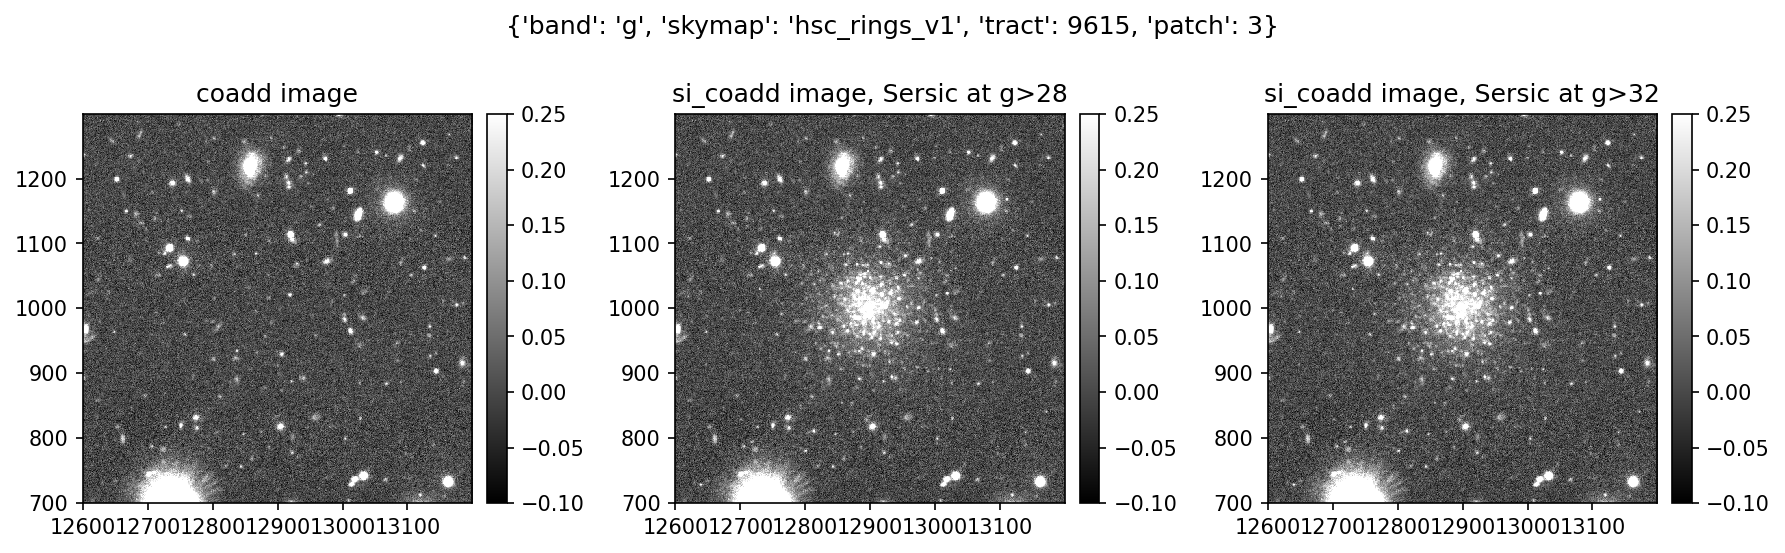

In [16]:
Q = 10

plot_si_coadd_g_lim28 = si_coadd_g_lim28.clone()
plot_si_coadd_g_lim32 = si_coadd_g_lim32.clone()
# plot_si_calexp.image.array = gaussian_filter(si_calexp.image.array, sigma=3)

fig, ax = plt.subplots(1, 3, figsize=(12, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
# display0.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
# display0.scale('linear', 'zscale')
display0.scale('linear', min=-0.10, max=0.25)
#display0.mtv(coadd_g.image)
display0.mtv(coadd_g.image[12600:13200, 700:1300])
plt.title('coadd image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
# display1.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
# display1.scale('linear', 'zscale')
display1.scale('linear', min=-0.10, max=0.25)
#display1.mtv(plot_si_coadd_g_lim28.image)
display1.mtv(plot_si_coadd_g_lim28.image[12600:13200, 700:1300])
# plt.plot(x, y, 'ro', fillstyle='none')
plt.title('si_coadd image, Sersic at g>28')

plt.sca(ax[2])
display1 = afwDisplay.Display(frame=fig)
# display1.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
# display1.scale('linear', 'zscale')
display1.scale('linear', min=-0.10, max=0.25)
#display1.mtv(plot_si_coadd_g_lim32.image)
display1.mtv(plot_si_coadd_g_lim32.image[12600:13200, 700:1300])
# plt.plot(x, y, 'ro', fillstyle='none')
plt.title('si_coadd image, Sersic at g>32')

plt.suptitle(str(dataid_g), y=0.8)
plt.tight_layout()
plt.show()

Hmmm. It looks like I should be giving the Sersic rhalf, and it should be in arcseconds rather than kpc.